In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.spatial.distance as dist

import sys

import pandas as pd

from expected_min_dist import expected_dist_conf, gen_centers

In [2]:
def greedy_step(servers, request, pd_edges):
    # Find the smallest distance between the servers and the point
    min_idx = -1
    min_dist = float('inf')
    dest = pd_edges[request]
    for i, server in enumerate(servers):
        request_dist = dist.euclidean(server, request)
        # Store if new min
        if request_dist < min_dist:
            min_dist = request_dist
            min_idx = i
    min_dist += dist.euclidean(request, dest)
    return min_idx, min_dist

def heuristic_step(servers, request, pd_edges, nu=1.):
    # Find the smallest distance between the servers and the point
    min_idx = -1
    min_dist = float('inf')
    min_loss = float('inf')
    dest = pd_edges[request]
    for i, server in enumerate(servers):
        request_dist = dist.euclidean(server, request)
        # Suppose we move the server, this is the new config
        future_servers = servers[: i] + [dest] + servers[i+1:]
        # Compute the future expected minimum distance
        exp_dist = expected_dist_conf(future_servers, draw=False)
        # This is the heuristic loss function
        loss = request_dist + nu*exp_dist
        # Store minimum
        if loss < min_loss:
            min_loss = loss
            min_dist = request_dist
            min_idx = i
    min_dist += dist.euclidean(request, dest)
    return min_idx, min_dist

In [3]:
# Run a kserver algorithm
def _run_kserver(alg_step, servers, requests, pd_edges, **kwargs):
    # Copy list
    cur_servers = list(servers)
    total_dist = 0.
    for request in requests:
        # Compute next step
        idx, min_dist = alg_step(cur_servers, request, pd_edges, **kwargs)
        total_dist += min_dist
        # Take the step
        cur_servers[idx] = pd_edges[request]
    return total_dist


def greedy_kserver(servers, requests, pd_edges):
    return _run_kserver(greedy_step, servers=servers, requests=requests, pd_edges=pd_edges)

def heuristic_kserver(servers, requests, pd_edges, nu=1.):
    return _run_kserver(heuristic_step, servers=servers, requests=requests, pd_edges=pd_edges, nu=nu)



In [9]:
experiment1 = {
    'num_requests': 100,
    'num_servers': 5,
    'num_reps': 5,
    'num_nus': 20
}

In [10]:
def run_mean_ratios_exp(num_requests, num_servers, num_reps, num_nus):
    nus = np.linspace(0, 5, num_nus)
    mean_ratios = {nu:0. for nu in nus}

    for i in xrange(num_reps):
        servers = gen_centers(num_servers)
        requests = gen_centers(num_requests)
        pd_edges = {req:gen_centers(1)[0] for req in requests}
        greedy_cost = greedy_kserver(servers, requests, pd_edges)

        for nu in nus:
            mean_ratios[nu] += heuristic_kserver(servers, requests, pd_edges, nu=nu) / greedy_cost
        print i

    for k,v in mean_ratios.iteritems():
        mean_ratios[k] = v/num_reps
    
        sys.stdout.flush()
    
    return nus, mean_ratios

In [11]:
def display_mean_ratios(num_servers, nus, mean_ratios):
    save_path = "results/ratio_plots/"
    fig, ax = plt.subplots()

    ax.plot(nus, list(mean_ratios[nu] for nu in nus))

    ax.set_xlabel(r"$\eta$", fontsize=15)
    ax.set_ylabel("Cost Ratio", fontsize=15)
    ax.set_title("Ratio heuristic to greedy (k={})".format(num_servers))
    plt.savefig("{}ave_ratio_2k{}.pdf".format(save_path, num_servers), 
                bbox_inches='tight')

0
1
2
3
4


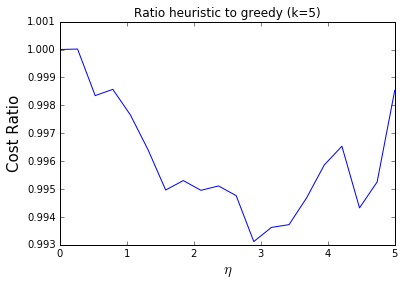

In [12]:
nus, mean_ratios = run_mean_ratios_exp(**experiment1)
display_mean_ratios(experiment1['num_servers'], nus, mean_ratios)

In [13]:
mean_ratios

{0.0: 1.0,
 0.26315789473684209: 1.0000162612127723,
 0.52631578947368418: 0.9983474335635301,
 0.78947368421052633: 0.9985720156066723,
 1.0526315789473684: 0.9976530107059223,
 1.3157894736842104: 0.9964052812001029,
 1.5789473684210527: 0.994963799500152,
 1.8421052631578947: 0.9953020381005417,
 2.1052631578947367: 0.9949528070793223,
 2.3684210526315788: 0.9951093303609861,
 2.6315789473684208: 0.9947629413027833,
 2.8947368421052628: 0.9931162289515985,
 3.1578947368421053: 0.9936229539472071,
 3.4210526315789473: 0.9937225785670384,
 3.6842105263157894: 0.994684869898052,
 3.9473684210526314: 0.9958613895248567,
 4.2105263157894735: 0.9965337659708349,
 4.4736842105263159: 0.9943239260114813,
 4.7368421052631575: 0.9952514265427942,
 5.0: 0.9985356192400807}

In [3]:
import time
print "finished", time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())

finished 2016-12-21 20:05:15
